# DLR + High Frequency Expansion Applied to DMFT

We apply the proposed DLR tailfitting scheme as an automatated way to tailfit the high-frequency regime of the Matsubara self-energy obtained from CT-QMC data.

Here, we model Sr$_{2}$RuO$_{4}$ using a combination of DFT+DMFT.

In [2]:
from triqs.gf import *
import numpy as np
import matplotlib.pyplot as plt
from h5 import HDFArchive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('publish')

In [3]:
from triqs.atom_diag import trace_rho_op
from triqs.operators import n

In [4]:
def max_G_diff(G1, G2, norm_temp = True):
    """
    calculates difference between two block Gfs
    uses numpy linalg norm on the last two indices first
    and then the norm along the mesh axis. The result is divided
    by sqrt(beta) for MeshImFreq and by sqrt(beta/#taupoints) for
    MeshImTime.
    1/ (2* sqrt(beta)) sqrt( sum_n sum_ij [abs(G1 - G2)_ij(w_n)]^2 )
    this is only done for MeshImFreq Gf objects, for all other
    meshes the weights are set to 1
    Parameters
    ----------
    G1 : Gf or BlockGf to compare
    G2 : Gf or BlockGf to compare
    norm_temp: bool, default = True
       divide by an additional sqrt(beta) to account for temperature scaling
       only correct for uniformly distributed error.
    __Returns:__
    diff : float
           difference between the two Gfs
    """

    if isinstance(G1, BlockGf):
        diff = 0.0
        for block, gf in G1:
            diff += max_G_diff(G1[block], G2[block], norm_temp)
        return diff

    assert G1.mesh == G2.mesh, 'mesh of two input Gfs does not match'
    assert G1.target_shape == G2.target_shape, 'can only compare Gfs with same shape'

    # subtract largest real value to make sure that G1-G2 falls off to 0
    if type(G1.mesh) is MeshImFreq:
        offset = np.diag(np.diag(G1.data[-1,:,:].real - G2.data[-1,:,:].real))
    else:
        offset = 0.0

    #  calculate norm over all axis but the first one which are frequencies
    norm_grid = abs(np.linalg.norm(G1.data - G2.data - offset, axis=tuple(range(1, G1.data.ndim))))
    # now calculate Frobenius norm over grid points
    norm = np.linalg.norm(norm_grid, axis=0)

    if type(G1.mesh) is MeshImFreq:
        norm = np.linalg.norm(norm_grid, axis=0) / np.sqrt(G1.mesh.beta)
    elif type(G1.mesh) is MeshImTime:
        norm = np.linalg.norm(norm_grid, axis=0) * np.sqrt(G1.mesh.beta/len(G1.mesh))
    elif type(G1.mesh) is MeshReFreq:
        norm = np.linalg.norm(norm_grid, axis=0) / np.sqrt(len(G1.mesh))
    else:
        raise ValueError('MeshReTime is not implemented')

    if type(G1.mesh) in (MeshImFreq, MeshImTime) and norm_temp:
        norm = norm / np.sqrt(G1.mesh.beta)

    return norm

In [5]:
tail_data = HDFArchive('sro_dmft_tail.h5')
dlr_data = { key : HDFArchive(f'sro_dmft_dlr_{key}1e-06.h5') for key in [40]}

KeyError: 80

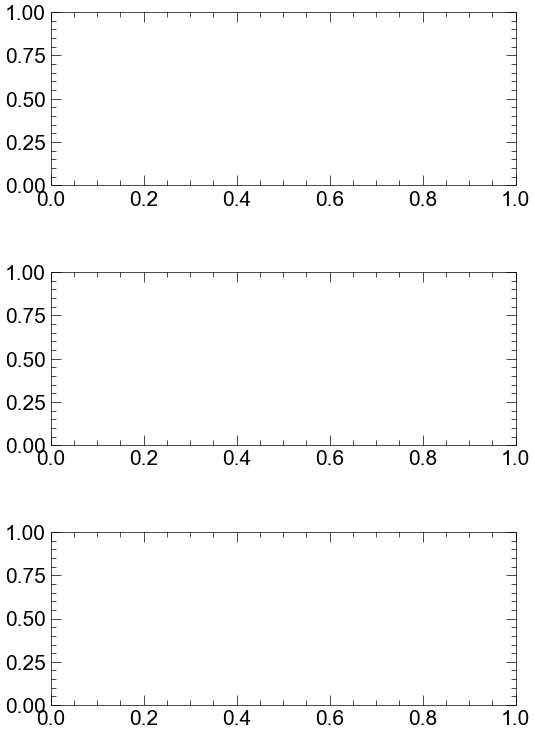

In [6]:
fig,ax = plt.subplots(3,1,figsize=(6,9))

plt.subplots_adjust(hspace=0.5)

for it in [20,34, 39,]:
    S_iw = dlr_data[80]['dmft_results']['it_{}'.format(it)]['Sigma_iw']
    iw = np.array([x.real+1j*x.imag for x in S_iw.mesh])
    for i in range(3):
        orb = str(i)*2
        ax[i].plot(iw.imag, S_iw['up'].data[:,i,i].imag, '-', lw=2, label='it={}'.format(it)) #label=r'Im$\Sigma^{'+orb+'}$'+' ($\Lambda = $'+str(key)+')')
        ax[i].set_ylim(-0.6,0)
        ax[i].legend(frameon=True, facecolor='white', edgecolor='white')
        ax[i].set_xlabel(r'$i\omega_{n}$'); #ax[i].set_ylabel('Im$\Sigma(i\omega_{n})$')
        ax[i].set_xlim(0, 30); 
for a, let in zip(ax, ['(a)', '(b)', '(c)']):
    a.text(-0.125, 1.125, let, transform = a.transAxes, size=20)
plt.show()

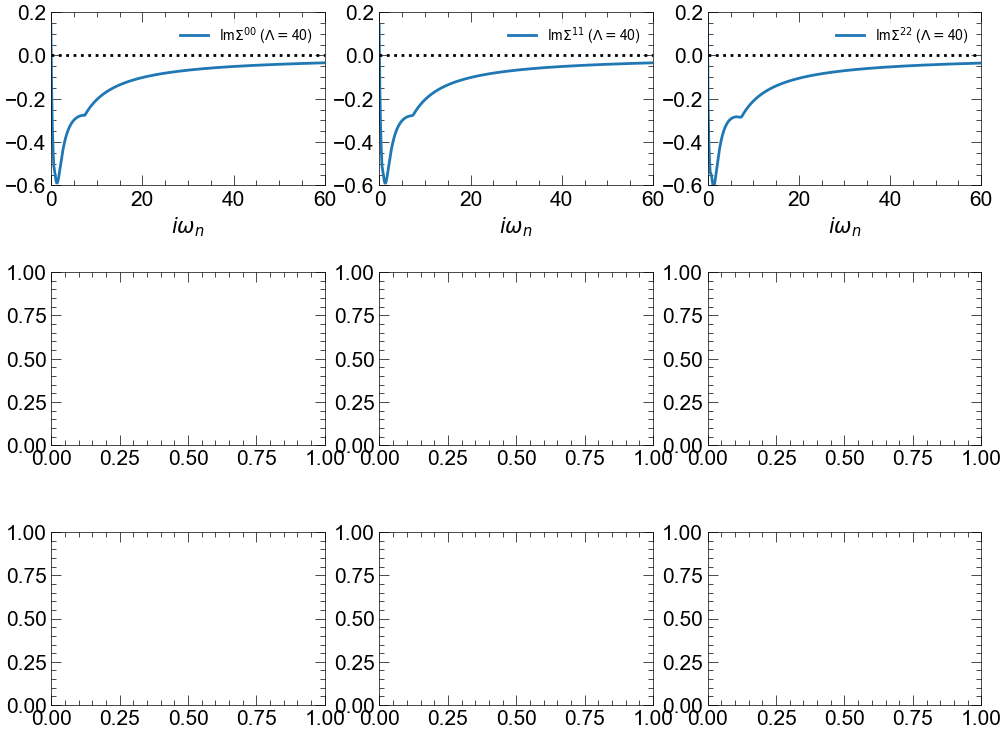

In [7]:
fig,ax = plt.subplots(3,3,figsize=(12,9))
plt.subplots_adjust(hspace=0.5)
for ikey, key in enumerate(dlr_data.keys()):
    S_iw = dlr_data[key]['dmft_results/last_iter']['Sigma_iw']
    iw = np.array([x.real+1j*x.imag for x in S_iw.mesh])
    for i in range(3):
        orb = str(i)*2
        ax[ikey, i].plot(iw.imag, S_iw['up'].data[:,i,i].imag, '-', lw=2,label=r'Im$\Sigma^{'+orb+'}$'+' ($\Lambda = $'+str(key)+')')
        ax[ikey, i].set_ylim(-0.6,0.2)
        ax[ikey, i].axhline(0.0, color='k', ls='dotted')
        ax[ikey, i].legend(frameon=True, facecolor='white', edgecolor='white')
        ax[ikey, i].set_xlabel(r'$i\omega_{n}$'); #ax[i].set_ylabel('Im$\Sigma(i\omega_{n})$')
        ax[ikey, i].set_xlim(0, 60); 
#for a, let in zip(ax, ['(a)', '(b)', '(c)']):
#    a.text(-0.125, 1.125, let, transform = a.transAxes, size=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(12, 6))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
S_iw_tail = tail_data['dmft_results/last_iter']['Sigma_iw']
for o in range(3):
    iw = np.array([x.real+1j*x.imag for x in S_iw_tail.mesh])
    ax[0,o].plot(iw.imag, S_iw_tail['up'].data[:,o,o].imag, 'k-', lw=2, label= 'Tail fit')
    for key in dlr_data.keys():
        S_iw = dlr_data[key]['dmft_results/last_iter']['Sigma_iw']
        iw = np.array([x.real+1j*x.imag for x in S_iw.mesh])
        ax[0,o].plot(iw.imag, S_iw['up'].data[:,o,o].imag, '-', lw=2,label=r'$\Lambda = $'+str(key));
        ax[1,o].loglog(iw.imag, np.abs(S_iw['up'].data[:,o,o].imag-S_iw_tail['up'].data[:,o,o].imag))

    ax[0,o].legend()
    ax[0,o].set_xlabel(r'$i\omega_{n}$'); ax[0,o].set_ylabel('Im$\Sigma^{'+str(o)+str(o)+'}(i\omega_{n})$')
    ax[1,o].set_xlabel(r'$i\omega_{n}$');
    ax[0,o].set_xlim(0, 25); ax[0,o].set_ylim(-0.5,0)
    ax[1,o].set_xlim(1, 200);
for a, let in zip(ax.flatten(), ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    a.text(-0.25, 1.125, let, transform = a.transAxes, size=20)
plt.show()

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(6,9))
plt.subplots_adjust(hspace=0.5)
key = 80
G0_iw = dlr_data[key]['dmft_results/last_iter']['G0_iw']
G_iw  = dlr_data[key]['dmft_results/last_iter']['G_iw']
S_iw_res  = dlr_data[key]['dmft_results/last_iter']['Sigma_iw']
sig_mom = dlr_data[key]['dmft_results/last_iter']['sigma_moments']
S_iw = inverse(G0_iw) - inverse(G_iw)
iw = np.array([x.real+1j*x.imag for x in S_iw.mesh])
pos_freq = np.where(iw.imag > 0)
mid = len(iw) // 2

for i in range(3):
    orb = str(i)*2
    #ax[i].plot(iw.imag, S_iw_res['up'].data[:,i,i].imag, '-', lw=2,label=r'Im$\Sigma^{'+orb+'}_{\mathrm{QMC}}$')
    ax[i].plot(iw.imag, S_iw['up'].data[:,i,i].imag, '-', lw=2,label=r'Im$\Sigma^{'+orb+'}_{\mathrm{DLR}}$')
    ASYMM = (sig_mom[0]['up'][i,i] + sig_mom[1]['up'][i,i]/iw)
    ax[i].plot(iw.imag, ASYMM.imag, '-', label=r'Im$\Sigma^{'+orb+'}_{\mathrm{asym. exp.}}$')
    switch = np.argmin(np.abs(S_iw['up'].data[:,i,i].imag-ASYMM.imag)[pos_freq]) + mid
    iwn_star = iw[switch].imag
    ax[i].axvline(iwn_star, color='k', lw=1)
    label=r'$i\omega_{n}^{\star}$ = '+'{:.0f}'.format(iwn_star)
    ax[i].text(iwn_star+0.75, -0.25, label)
    ax[i].set_ylim(-0.6,0)
    ax[i].legend(frameon=True, facecolor='white', edgecolor='white')
    ax[i].set_xlabel(r'$i\omega_{n}$'); #ax[i].set_ylabel('Im$\Sigma(i\omega_{n})$')
    ax[i].set_xlim(0, 80);
for a, let in zip(ax, ['(a)', '(b)', '(c)']):
    a.text(-0.125, 1.125, let, transform = a.transAxes, size=20)
plt.show()

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(6,9))
plt.subplots_adjust(hspace=0.5)
key = 80
G0_iw = dlr_data[key]['dmft_results/last_iter']['G0_iw']
G_iw  = dlr_data[key]['dmft_results/last_iter']['G_iw']
S_iw_res  = dlr_data[key]['dmft_results/last_iter']['Sigma_iw']
sig_mom = dlr_data[key]['dmft_results/last_iter']['sigma_moments']
S_iw = inverse(G0_iw) - inverse(G_iw)
iw = np.array([x.real+1j*x.imag for x in S_iw.mesh])
pos_freq = np.where(iw.imag > 0)
mid = len(iw) // 2

for i in range(3):
    orb = str(i)*2
    #ax[i].plot(iw.imag, S_iw_res['down'].data[:,i,i].imag, '-', lw=2,label=r'Im$\Sigma^{'+orb+'}_{\mathrm{QMC}}$')
    ax[i].plot(iw.imag, S_iw['down'].data[:,i,i].imag, '-', lw=2,label=r'Im$\Sigma^{'+orb+'}_{\mathrm{DLR}}$')
    ASYMM = (sig_mom[0]['down'][i,i] + sig_mom[1]['down'][i,i]/iw)
    ax[i].plot(iw.imag, ASYMM.imag, '-', label=r'Im$\Sigma^{'+orb+'}_{\mathrm{asym. exp.}}$')
    switch = np.argmin(np.abs(S_iw['down'].data[:,i,i].imag-ASYMM.imag)[pos_freq]) + mid
    iwn_star = iw[switch].imag
    ax[i].axvline(iwn_star, color='k', lw=1)
    label=r'$i\omega_{n}^{\star}$ = '+'{:.0f}'.format(iwn_star)
    ax[i].text(iwn_star+0.75, -0.25, label)
    ax[i].set_ylim(-0.6,0)
    ax[i].legend(frameon=True, facecolor='white', edgecolor='white')
    ax[i].set_xlabel(r'$i\omega_{n}$'); #ax[i].set_ylabel('Im$\Sigma(i\omega_{n})$')
    ax[i].set_xlim(0, 80);
for a, let in zip(ax, ['(a)', '(b)', '(c)']):
    a.text(-0.125, 1.125, let, transform = a.transAxes, size=20)
plt.show()

In [ ]:
def make_fourier(Gtau, Giw):
    Gtau_new = Gtau.copy()
    for bl, gtau in Gtau_new:
        gtau.set_from_fourier(Giw[bl])
    return Gtau_new

In [ ]:
def nimp_density(dm, hdiag):
    density = 0
    for i in range(3):
        density += trace_rho_op(dm, n('up', i), hdiag)+trace_rho_op(dm, n('down', i), hdiag)
    return density

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(6,9))
plt.subplots_adjust(hspace=0.5)
for ls, label, ar in zip(['o-', 'x-', 'x-','x-'], ['Tail fit', '$\Lambda = $20', '$\Lambda = $40','$\Lambda = $80' ],
                                                    [tail_data, dlr_data[20], dlr_data[40],dlr_data[80]]):
    mu, nlat, nimp, diffG = [], [], [], []
    max_iter = min(ar['dmft_results']['iterations'], 40)
    for it in range(max_iter):
        mu.append(ar['dmft_results/it_{}'.format(it)]['mu'])
        nlat.append(ar['dmft_results/it_{}'.format(it)]['n_latt'])
        try:
            nimp.append(nimp_density(ar['dmft_results/it_{}'.format(it)]['density_matrix'], 
                                     ar['dmft_results/it_{}'.format(it)]['h_loc_diag']))
        except:
            nimp.append(ar['dmft_results/it_{}'.format(it)]['n_imp'])
        G1 = ar['dmft_results/it_{}'.format(it)]['G_tau']
        G2 = make_fourier(G1, ar['dmft_results/it_{}'.format(it)]['Gloc'])
        diffG.append(max_G_diff(G1, G2))
    
    ax[0].semilogy(list(range(max_iter-1)), np.abs(np.diff(mu)), ls, lw=1, label=label)
    #ax[0].axhline(np.std(np.abs(np.diff(mu))[-5:]), color=line.get_color())
    ax[1].semilogy(list(range(max_iter-1)), np.abs(np.diff(nimp)), ls, lw=1)
    #ax[1].axhline(np.std(np.abs(np.diff(nimp))[-5:]), color=line.get_color())
    ax[2].semilogy(list(range(max_iter)), diffG, ls, lw=1)
ax[0].legend()
ax[0].set_ylabel(r'$\delta \mu$'); ax[0].set_xlabel('Iteration')
ax[1].set_ylabel(r'$\delta n_{\mathrm{imp}}$'); ax[1].set_xlabel('Iteration')
ax[2].set_ylabel(r'|$G_{\mathrm{imp}}(\tau)$ - $G_{\mathrm{loc}}(\tau)$|'); ax[2].set_xlabel('Iteration')
ax[0].set_ylim(1e-5, 1); ax[1].set_ylim(1e-5, 1); ax[2].set_ylim(1e-3, 1)
ax[0].grid(); ax[1].grid(); ax[2].grid()
ax[0].set_xticks([0,10,20,30,40])
ax[1].set_xticks([0,10,20,30,40])
ax[2].set_xticks([0,10,20,30,40])
for a, let in zip(ax, ['(a)', '(b)', '(c)']):
    a.text(-0.125, 1.125, let, transform = a.transAxes, size=20)
plt.show()